# ResNet‑18 Transfer Learning: Baseline, Hyperparameter Tuning and Fine‑Tuning

This notebook reproduces the ResNet‑18 transfer‑learning pipeline on Flowers102 and evaluates freezing strategies.
The goal is to show how transfer learning, hyperparameters, and layer freezing affect validation and test accuracy.

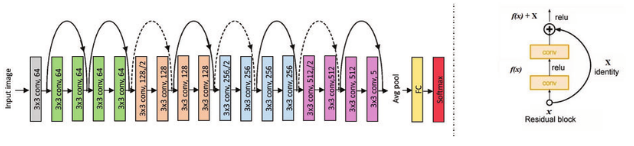

## Imports and Reproducibility Setup 

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
from itertools import product
import copy, time
import torch.optim as optim
import random, scipy

# For reproducibility
seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)

In [2]:
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda"), "CUDA"
    try:
        import torch_directml as dml
        if hasattr(dml, "is_available") and dml.is_available():
            return dml.device(), "DirectML"
    except Exception as e:
        print("DirectML init error:", e)
    if hasattr(torch, "xpu") and getattr(torch.xpu, "is_available", lambda: False)():
        return torch.device("xpu"), "Intel XPU"
    # Fallback
    return torch.device("cpu"), "CPU"

device, backend = pick_device()
print(f"Using backend: {backend} on device: {device}")

Using backend: DirectML on device: privateuseone:0


## Data Preparation  

In [5]:
# Resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [9]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## 1. Baseline Model - ResNet18 Transfer Learning

Transfer learning initialises the backbone with pre-trained weights from ImageNet. The final fully-connected (FC) layer is then replaced to match 102 flower classes, followed by further fine-tuning and training on the Flowers102 dataset. We established a transfer learning baseline by fine-tuning the pre-trained model, with a learning rate of 0.001, batch size of 32, and no dropout and weight decay. 


In [11]:
# Early stopping class
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
            return False

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True

        return False


In [14]:
# Define loss function
criterion = nn.CrossEntropyLoss()

def train_resnet18_baseline(
    lr=0.001,
    weight_decay=0.0,
    num_epochs=100,
    patience=5
):
    """
    Baseline ResNet18 training on Flowers102.
    Selects best model by validation accuracy (ties broken by lower val loss),
    then reports Test Acc from that best checkpoint.
    """

    # Create ResNet‑18 with ImageNet weights and replace the final FC for 102 classes.
    # Transfer learning baseline, set weights="IMAGENET1K_V1".
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 102)
    model = model.to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,foreach=False)

    best_val_acc = 0.0
    best_val_loss = float("inf")
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []


    for epoch in range(1, num_epochs + 1):
        # -------- Training --------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for X, y in train_loader:
            # Compute prediction and loss
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Backpropagation
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # -------- Validation --------
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                logits = model(X)
                loss = criterion(logits, y)

                val_running_loss += loss.item() * X.size(0)
                preds = logits.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

        # Track best model
        improved = False

        if val_acc > best_val_acc:
            improved = True
        elif abs(val_acc - best_val_acc) < 1e-8 and val_loss < best_val_loss - 1e-6:
            # tie on acc, better loss
            improved = True

        if improved:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping 
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # ============================================
    # Load best model and evaluate on test set
    # ============================================
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    else:
        print("Warning: No improvement tracked; using last epoch model.")

    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(X)
            preds = logits.argmax(dim=1)
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_acc = test_correct / test_total

    print(f"\nBest Val Acc: {best_val_acc:.4f}")
    print(f"Test Acc (using best-val checkpoint): {test_acc:.4f}")

    history = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accuracies,
        "val_acc": val_accuracies,
    }

    return model, history, best_val_acc, test_acc

In [16]:
baseline_model, history, best_val_acc, test_acc = train_resnet18_baseline(
    lr=0.001,
    weight_decay=0.0,
    num_epochs=100,
    patience=5
)

C:\Users\nguiy\anaconda3\envs\torch-dml\lib\site-packages\torch\optim\adam.py:379: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  exp_avg.lerp_(grad, 1 - beta1)


Epoch 1/100 | Train Loss: 3.5593 | Train Acc: 0.2216 | Val Loss: 2.5894 | Val Acc: 0.3725
Epoch 2/100 | Train Loss: 1.3228 | Train Acc: 0.6990 | Val Loss: 1.5518 | Val Acc: 0.5843
Epoch 3/100 | Train Loss: 0.4708 | Train Acc: 0.9127 | Val Loss: 1.2804 | Val Acc: 0.6804
Epoch 4/100 | Train Loss: 0.1740 | Train Acc: 0.9765 | Val Loss: 1.0493 | Val Acc: 0.7441
Epoch 5/100 | Train Loss: 0.0867 | Train Acc: 0.9892 | Val Loss: 0.8317 | Val Acc: 0.8010
Epoch 6/100 | Train Loss: 0.0562 | Train Acc: 0.9931 | Val Loss: 0.8556 | Val Acc: 0.7804
Epoch 7/100 | Train Loss: 0.0378 | Train Acc: 0.9931 | Val Loss: 0.8553 | Val Acc: 0.7873
Epoch 8/100 | Train Loss: 0.0403 | Train Acc: 0.9961 | Val Loss: 1.1822 | Val Acc: 0.7324
Epoch 9/100 | Train Loss: 0.0485 | Train Acc: 0.9922 | Val Loss: 1.1203 | Val Acc: 0.7275
Epoch 10/100 | Train Loss: 0.0885 | Train Acc: 0.9863 | Val Loss: 1.6407 | Val Acc: 0.5912
Early stopping triggered at epoch 10

Best Val Acc: 0.8010
Test Acc (using best-val checkpoint): 0.

In [17]:
def plot_loss_and_accuracy(history):
    tr_loss = history["train_loss"]
    v_loss = history["val_loss"]
    tr_acc = history["train_acc"]
    v_acc = history["val_acc"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Loss vs Epochs
    ax1.plot(tr_loss, label='Train Loss')
    ax1.plot(v_loss, label='Val Loss')
    ax1.set_title('Train vs Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()
    
    # Accuracy vs Epochs
    ax2.plot(tr_acc, label='Train Acc')
    ax2.plot(v_acc, label='Val Acc')
    ax2.set_title('Train vs Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()


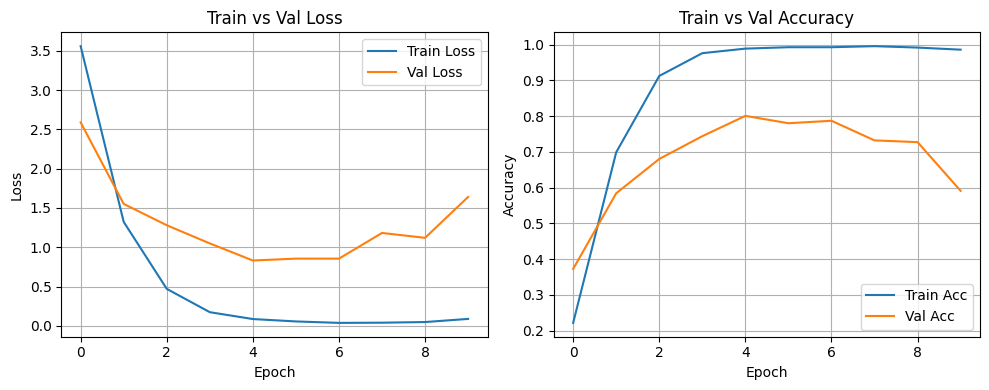

In [18]:
plot_loss_and_accuracy(history)

In [19]:
print(f"\n[Summary] Baseline ResNet18 | Best Val Acc: {best_val_acc:.4f} | Test Acc: {test_acc:.4f}")


[Summary] Baseline ResNet18 | Best Val Acc: 0.8010 | Test Acc: 0.7603


## 2. Baseline ResNet18 Model with Hyperparameter Tuning
Hyperparameter tuning was then conducted by experimenting with different permutations of learning rate and batch size, finding the optimal learning rate and batch size that achieves the highest validation accuracy. After hyperparameter tuning, various configurations of dropout and weight decay values were tested.

To ensure fair comparison, all subsequent ResNet18 models use these optimal configurations unless specified.

In [21]:
# Define Dataloaders
def make_loaders(batch_size: int):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader

In [22]:
# Create ResNet‑18 with ImageNet weights and replace the final FC for 102 classes, reusable for each configuration
def build_resnet18_with_dropout(dropout_p: float):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    if dropout_p > 0.0:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features, 102)
        )
    else:
        model.fc = nn.Linear(in_features, 102)
    model = model.to(device) 
    return model

In [23]:
def train_resnet_config(lr,
                        batch_size,
                        dropout,
                        weight_decay,
                        max_epochs=100,
                        patience=5):
    """
    Train a single ResNet18 config and return:
      best_val_acc, test_acc,
      train_losses, train_accuracies,
      val_losses, val_accuracies,
      epochs_ran, best_model_state
    """
    
    # fresh loaders for this config
    train_loader, val_loader, test_loader = make_loaders(batch_size)

    # Initialise model, optimizer, loss function, early stopper for this config
    model = build_resnet18_with_dropout(dropout)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, foreach=False)

    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, max_epochs + 1):
        # -------- Training --------
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for X, y in train_loader:
            # Compute prediction and loss
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)

            # Backpropagation
            loss.backward()
            optimizer.step()

            bs = y.size(0)
            total_loss += loss.item() * bs
            total += bs
            correct += (logits.argmax(dim=1) == y).sum().item()

        train_loss = total_loss / max(total, 1)
        train_acc = correct / max(total, 1)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # -------- Validation --------
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                logits = model(X)
                loss = criterion(logits, y)

                bs = y.size(0)
                val_loss += loss.item() * bs
                val_total += bs
                val_correct += (logits.argmax(dim=1) == y).sum().item()

        val_loss /= max(val_total, 1)
        val_acc = val_correct / max(val_total, 1)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch} | Train Loss={train_loss:.4f} | Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}"
        )

        # Track best model-
        improved = False
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            improved = True
        elif val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            improved = True

        if improved:
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    epochs_ran = epoch

    # Test using best model 
    if best_model_state is None:
        best_model_state = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_state)
    model.eval()

    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(X)
            loss = criterion(logits, y)

            bs = y.size(0)
            test_loss += loss.item() * bs
            total += bs
            correct += (logits.argmax(dim=1) == y).sum().item()

    test_loss /= max(total, 1)
    test_acc = correct / max(total, 1)

    print(f"→ Best Val Acc: {best_val_acc:.4f}, Test Acc: {test_acc:.4f}")

    return (
        best_val_acc,
        test_acc,
        train_losses,
        train_accuracies,
        val_losses,
        val_accuracies,
        epochs_ran,
        best_model_state
    )


### Stage 1: Hyperparameter Tuning

| Parameter       | Values Tested       | Rationale |
|-----------------|------------------|-----------|
| Learning Rate    | 5e-4, 1e-4, 1e-3 | Covers conservative, standard, and aggressive training speeds. |
| Batch Size       | 16, 32, 64            | Trade-off between noisy and smooth gradient updates for generalization and stability. |

To reduce the number of permutations, we first find the best learning rate and batch size (Stage 1), then use these best hyperparameters to find the best regularisation parameters (Stage 2).

In [24]:
LR_GRID    = [5e-4, 1e-4, 1e-3]
BATCH_GRID = [16, 32, 64]

# Store stage 1 results
stage1_results = []

for lr, batch_size in product(LR_GRID, BATCH_GRID):
    print("\n" + "="*70)
    print(f"Stage 1 - Config: lr={lr}, batch_size={batch_size}, dropout=0.0, wd=0.0")

    (
        best_val_acc,
        test_acc,
        tr_losses,
        tr_accs,
        val_losses,
        val_accs,
        epochs_ran,
        state
    ) = train_resnet_config(
        lr=lr,
        batch_size=batch_size,
        dropout=0.0,
        weight_decay=0.0,
        max_epochs=30,
        patience=5
    )

    best_val_loss = min(val_losses) if len(val_losses) > 0 else float("inf")

    stage1_results.append({
        "lr": lr,
        "batch_size": batch_size,
        "dropout": 0.0,
        "weight_decay": 0.0,
        "best_val_loss": best_val_loss,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "epochs_ran": epochs_ran,
        "train_losses": tr_losses,
        "train_accuracies": tr_accs,
        "val_losses": val_losses,
        "val_accuracies": val_accs,
        "model_state": state,
    })

# pick best Stage 1 config by validation accuracy
stage1_best = max(stage1_results, key=lambda x: x["best_val_acc"])

print("\n" + "="*70)
print("Stage 1 Best ResNet18 (Tuned):")
print(f"  lr={stage1_best['lr']}")
print(f"  batch_size={stage1_best['batch_size']}")
print(f"  dropout={stage1_best['dropout']}")
print(f"  weight_decay={stage1_best['weight_decay']}")
print(f"  best_val_acc={stage1_best['best_val_acc']:.4f}")
print(f"  test_acc={stage1_best['test_acc']:.4f}")
print(f"  epochs_ran={stage1_best['epochs_ran']}")



Stage 1 - Config: lr=0.0005, batch_size=16, dropout=0.0, wd=0.0
Epoch 1 | Train Loss=3.3629 | Train Acc=0.3118 | Val Loss=1.8489 | Val Acc=0.5608
Epoch 2 | Train Loss=0.9888 | Train Acc=0.8480 | Val Loss=1.1464 | Val Acc=0.7304
Epoch 3 | Train Loss=0.2492 | Train Acc=0.9775 | Val Loss=0.7598 | Val Acc=0.8451
Epoch 4 | Train Loss=0.0769 | Train Acc=0.9951 | Val Loss=0.6472 | Val Acc=0.8578
Epoch 5 | Train Loss=0.0365 | Train Acc=1.0000 | Val Loss=0.6122 | Val Acc=0.8647
Epoch 6 | Train Loss=0.0197 | Train Acc=1.0000 | Val Loss=0.5490 | Val Acc=0.8804
Epoch 7 | Train Loss=0.0112 | Train Acc=1.0000 | Val Loss=0.5029 | Val Acc=0.8931
Epoch 8 | Train Loss=0.0076 | Train Acc=1.0000 | Val Loss=0.4933 | Val Acc=0.9000
Epoch 9 | Train Loss=0.0059 | Train Acc=1.0000 | Val Loss=0.4910 | Val Acc=0.8912
Epoch 10 | Train Loss=0.0050 | Train Acc=1.0000 | Val Loss=0.4714 | Val Acc=0.8971
Epoch 11 | Train Loss=0.0052 | Train Acc=1.0000 | Val Loss=0.4949 | Val Acc=0.8931
Epoch 12 | Train Loss=0.0048 | 

In [25]:
best_base_config = {
    "lr": stage1_best["lr"],
    "batch_size": stage1_best["batch_size"],
    "dropout": stage1_best["dropout"],
    "weight_decay": stage1_best["weight_decay"],
}


In [26]:
def plot_loss_and_accuracy(tr_loss, tr_acc, val_loss, val_acc, title):
    epochs = range(1, len(tr_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

    # Loss vs Epoch curves
    ax1.plot(epochs, tr_loss, label='Train Loss')
    ax1.plot(epochs, val_loss, label='Val Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    # Accuracy vs Epoch curves
    ax2.plot(epochs, tr_acc, label='Train Acc')
    ax2.plot(epochs, val_acc, label='Val Acc')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()


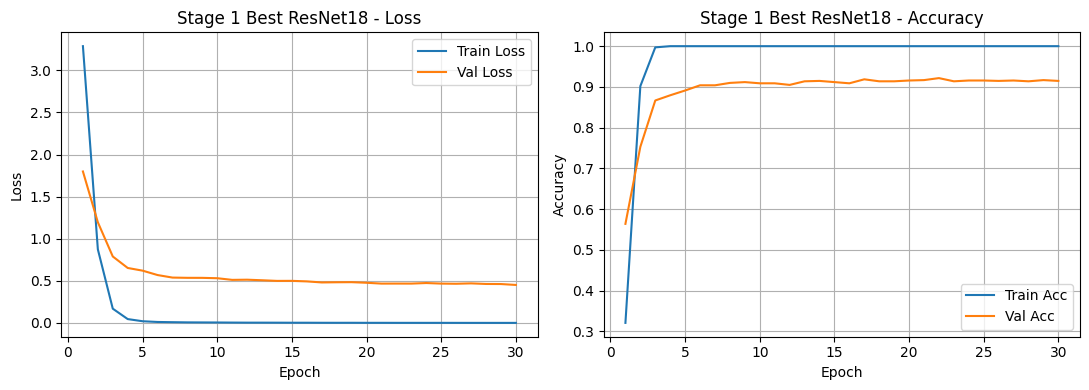

In [27]:
plot_loss_and_accuracy(
    stage1_best["train_losses"],
    stage1_best["train_accuracies"],
    stage1_best["val_losses"],
    stage1_best["val_accuracies"],
    title="Stage 1 Best ResNet18"
)


### Stage 2: Regularization Strategies


| Parameter       | Values Tested       |
|-----------------|------------------|
| Dropout    | 0, 0.2, 0.3 | 
| L2 Penalty      | 0, 1e-5, 1e-4            | 


In [29]:
DROPOUT_ONLY    = [0.2, 0.3]
L2_ONLY         = [1e-5, 1e-4]
DROPOUT_COMBOS  = [0.2, 0.3]
L2_COMBOS       = [1e-5, 1e-4]

# Store results for Stage 2
REG_CONFIGS = []

# Dropout only
for d in DROPOUT_ONLY:
    REG_CONFIGS.append((d, 0.0))

# L2 only
for wd in L2_ONLY:
    REG_CONFIGS.append((0.0, wd))

# Dropout + L2 combos
for d, wd in product(DROPOUT_COMBOS, L2_COMBOS):
    REG_CONFIGS.append((d, wd))

stage2_results = []

for dropout_p, weight_decay in REG_CONFIGS:
    print("\n" + "="*70)
    print(
        f"Stage 2 - Config: lr={best_base_config['lr']}, "
        f"batch={best_base_config['batch_size']}, "
        f"dropout={dropout_p}, wd={weight_decay}"
    )

    (
        best_val_acc,
        test_acc,
        tr_losses,
        tr_accs,
        val_losses,
        val_accs,
        epochs_ran,
        state
    ) = train_resnet_config(
        lr=best_base_config["lr"],
        batch_size=best_base_config["batch_size"],
        dropout=dropout_p,
        weight_decay=weight_decay,
        max_epochs=30,
        patience=5
    )

    best_val_loss = min(val_losses) if len(val_losses) > 0 else float("inf")

    stage2_results.append({
        "dropout": dropout_p,
        "weight_decay": weight_decay,
        "best_val_loss": best_val_loss,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "epochs_ran": epochs_ran,
        "train_losses": tr_losses,
        "train_accuracies": tr_accs,
        "val_losses": val_losses,
        "val_accuracies": val_accs,
        "model_state": state
    })

# pick best Stage 2 config by validation accuracy
stage2_best = max(stage2_results, key=lambda x: x["best_val_acc"])

print("\n" + "="*70)
print("Stage 2 - Best Config (by Val Acc):")
print(
    f"dropout={stage2_best['dropout']}, "
    f"weight_decay={stage2_best['weight_decay']}, "
    f"best_val_acc={stage2_best['best_val_acc']:.4f}, "
    f"test_acc={stage2_best['test_acc']:.4f}, "
    f"epochs_ran={stage2_best['epochs_ran']}"
)


Stage 2 - Config: lr=0.0005, batch=32, dropout=0.2, wd=0.0
Epoch 1 | Train Loss=3.4877 | Train Acc=0.2902 | Val Loss=1.8795 | Val Acc=0.5784
Epoch 2 | Train Loss=1.0488 | Train Acc=0.8725 | Val Loss=1.1797 | Val Acc=0.7892
Epoch 3 | Train Loss=0.2568 | Train Acc=0.9882 | Val Loss=0.9048 | Val Acc=0.8500
Epoch 4 | Train Loss=0.0762 | Train Acc=1.0000 | Val Loss=0.7727 | Val Acc=0.8686
Epoch 5 | Train Loss=0.0325 | Train Acc=1.0000 | Val Loss=0.6362 | Val Acc=0.8961
Epoch 6 | Train Loss=0.0171 | Train Acc=1.0000 | Val Loss=0.6098 | Val Acc=0.8971
Epoch 7 | Train Loss=0.0124 | Train Acc=1.0000 | Val Loss=0.5925 | Val Acc=0.8990
Epoch 8 | Train Loss=0.0097 | Train Acc=1.0000 | Val Loss=0.5904 | Val Acc=0.9049
Epoch 9 | Train Loss=0.0095 | Train Acc=1.0000 | Val Loss=0.5739 | Val Acc=0.8961
Epoch 10 | Train Loss=0.0074 | Train Acc=1.0000 | Val Loss=0.5660 | Val Acc=0.9049
Epoch 11 | Train Loss=0.0058 | Train Acc=1.0000 | Val Loss=0.5667 | Val Acc=0.9049
Epoch 12 | Train Loss=0.0050 | Train

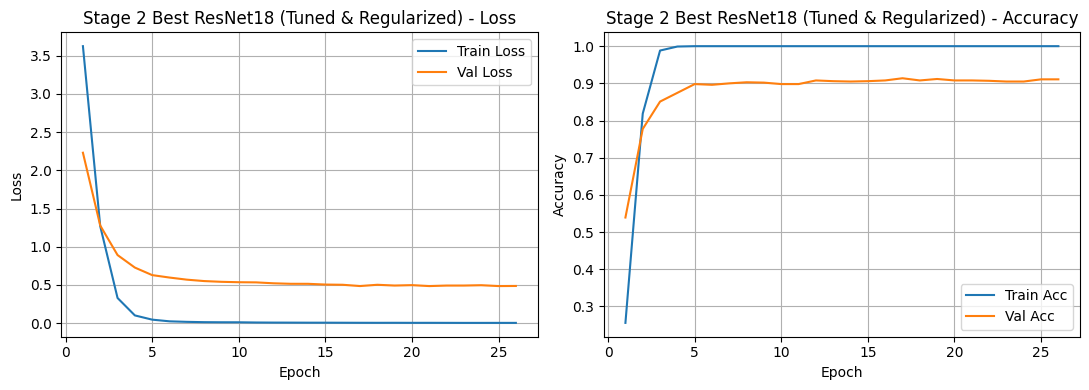

In [30]:
# Plot curves for best Stage 2 config
plot_loss_and_accuracy(
    stage2_best["train_losses"],
    stage2_best["train_accuracies"],
    stage2_best["val_losses"],
    stage2_best["val_accuracies"],
    title="Stage 2 Best ResNet18 (Tuned & Regularized)"
)



In [31]:
# Store best Config to be used for all later experiments
BEST_RESNET_CONFIG = {
    "lr": best_base_config["lr"],
    "batch_size": best_base_config["batch_size"],
    "dropout": stage2_best["dropout"],
    "weight_decay": stage2_best["weight_decay"],
    "best_val_acc": stage2_best["best_val_acc"],
    "test_acc": stage2_best["test_acc"],
}

print("\nFinal chosen baseline ResNet18 config (for all later experiments):")
print(BEST_RESNET_CONFIG)


Final chosen baseline ResNet18 config (for all later experiments):
{'lr': 0.0005, 'batch_size': 32, 'dropout': 0.3, 'weight_decay': 0.0001, 'best_val_acc': 0.9137254901960784, 'test_acc': 0.870710684664173}


## 3. ResNet18 Model with Different Number of Frozen Layers
Freezing earlier layers preserve general features learned from ImageNet dataset and leave only the final task-specific layers to be trained to adapt to the Flowers102 dataset, hence mitigating overfitting. Furthermore, freezing layers improves computational efficiency by reducing the number of trainable parameters. 

Building on the final baseline model, we progressively froze k stages in the pre-trained ResNet18 model, where k ranges from 0 to 4. When k equals to 0, all layers are trainable. When k equals to 1, the stem, with the initial layers for input processing, is frozen. As k increases from 2 to 4, one additional residual stage after the stem is frozen each time. The final FC layer remains trainable in all experiments. The Adam optimizer only updates the parameters of layers with requires_grad = True. 

Here are the variants tested:
| Stages Frozen       | 
|-----------------|
| Stem    | 
| Stem + Stage 1 | 
| Stem + Stages 1-2 | 
| Stem + Stages 1-3 | 
| Stem + Stages 1-4 | 

In [33]:
def freeze_resnet18_stages(model, num_frozen_stages: int):
    """
    Freeze the first `num_frozen_stages` ResNet-18 stages.

    Convention:
      0: no freezing (all trainable)
      1: freeze stem (conv1/bn1/relu/maxpool) + layer1
      2: additionally freeze layer2
      3: additionally freeze layer3
      4: additionally freeze layer4

    FC head always remains trainable.
    """
    # Unfreeze everything first
    for p in model.parameters():
        p.requires_grad = True

    if num_frozen_stages >= 1:
        for m in [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1]:
            for p in m.parameters():
                p.requires_grad = False

    if num_frozen_stages >= 2:
        for p in model.layer2.parameters():
            p.requires_grad = False

    if num_frozen_stages >= 3:
        for p in model.layer3.parameters():
            p.requires_grad = False

    if num_frozen_stages >= 4:
        for p in model.layer4.parameters():
            p.requires_grad = False

    # Keep classifier trainable
    for p in model.fc.parameters():
        p.requires_grad = True

    return model


def train_resnet_frozen_single(num_frozen_stages,
                               hp,
                               max_epochs=30,
                               patience=5):
    """
    Train one config of ResNet18 with `num_frozen_stages` frozen.

    hp expects:
      - "lr"
      - "batch_size"
      - "dropout"
      - "weight_decay"

    Returns:
      {
        "k": num_frozen_stages,
        "best_val_acc",
        "best_val_loss",
        "test_acc",
        "epochs_ran",
        "train_losses",
        "train_accuracies",
        "val_losses",
        "val_accuracies",
        "model_state",
      }
    """
    lr = hp["lr"]
    batch_size = hp["batch_size"]
    dropout_p = hp["dropout"]
    weight_decay = hp["weight_decay"]

    # loaders for this batch size
    train_loader, val_loader, test_loader = make_loaders(batch_size)

    # build model + freeze
    model = build_resnet18_with_dropout(dropout_p)
    model = freeze_resnet18_stages(model, num_frozen_stages)
    model = model.to(device) 

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=weight_decay,
        foreach=False
    )

    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, max_epochs + 1):
        # -------- Training --------
        model.train()
        total_loss = 0.0
        total_samples = 0
        correct_train = 0

        for X, y in train_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            bs = y.size(0)
            total_loss += loss.item() * bs
            total_samples += bs
            preds = logits.argmax(dim=1)
            correct_train += (preds == y).sum().item()

        train_loss = total_loss / max(total_samples, 1)
        train_acc = correct_train / max(total_samples, 1)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # -------- Validation --------
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                logits = model(X)
                loss = criterion(logits, y)
                bs = y.size(0)

                val_loss += loss.item() * bs
                total += bs
                correct += (logits.argmax(dim=1) == y).sum().item()

        val_loss /= max(total, 1)
        val_acc = correct / max(total, 1)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"[Frozen {num_frozen_stages}] "
            f"Epoch {epoch} | Train Loss={train_loss:.4f} | Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}"
        )

        # Track best model
        improved = False
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            improved = True
        elif val_acc == best_val_acc and val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            improved = True
        elif val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            improved = True

        if improved:
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"[Frozen {num_frozen_stages}] Early stopping at epoch {epoch}")
            break

    epochs_ran = epoch

    # Test on best checkpoint
    if best_model_state is None:
        best_model_state = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_state)
    model.eval()

    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(X)
            loss = criterion(logits, y)
            test_loss += loss.item() * y.size(0)
            total += y.size(0)
            correct += (logits.argmax(dim=1) == y).sum().item()

    test_loss /= max(total, 1)
    test_acc = correct / max(total, 1)

    print(
        f"[Frozen {num_frozen_stages}] "
        f"| Best Val Acc={best_val_acc:.4f} | Test Acc={test_acc:.4f}"
    )

    return {
        "k": num_frozen_stages,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "test_acc": test_acc,
        "epochs_ran": epochs_ran,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "model_state": best_model_state
    }


def run_resnet18_frozen_stages_experiments(
    frozen_stage_list,
    best_hp,
    max_epochs=30,
    patience=5
):
    """
    Run frozen-stage experiments for each k in frozen_stage_list
    using tuned hyperparameters `BEST_RESNET_CONFIG`.

    Returns:
      results_dict: {k: result_dict}
      best_k: k with highest best_val_acc
      best_result: result_dict for best_k
    """
    results = {}
    best_k = None
    best_result = None
    best_val_acc_global = -1.0

    for k in frozen_stage_list:
        print("\n" + "="*70)
        print(f"Running frozen-stage config: k={k}")

        res = train_resnet_frozen_single(
            num_frozen_stages=k,
            hp=best_hp,
            max_epochs=max_epochs,
            patience=patience
        )
        results[k] = res

        if res["best_val_acc"] > best_val_acc_global:
            best_val_acc_global = res["best_val_acc"]
            best_k = k
            best_result = res

    # Summary print
    print("\n" + "="*70)
    print("Frozen Stages Summary (Best Val Acc & Test Acc):")
    for k in frozen_stage_list:
        r = results[k]
        print(
            f"k={k} | "
            f"Best Val Acc={r['best_val_acc']:.4f} | "
            f"Test Acc={r['test_acc']:.4f}"
        )

    print(
        f"\nBest config: k={best_k} "
        f"with Best Val Acc={best_result['best_val_acc']:.4f}, "
        f"Test Acc={best_result['test_acc']:.4f}"
    )

    return results, best_k, best_result



In [40]:
# Use tuned Stage 2 hyperparams
best_hp_frozen = {
    "lr": BEST_RESNET_CONFIG["lr"],
    "batch_size": BEST_RESNET_CONFIG["batch_size"],
    "dropout": BEST_RESNET_CONFIG["dropout"],
    "weight_decay": BEST_RESNET_CONFIG["weight_decay"],
}

frozen_stage_list = [0, 1, 2, 3, 4]

frozen_results, best_frozen_k, best_frozen_result = run_resnet18_frozen_stages_experiments(
    frozen_stage_list=frozen_stage_list,
    best_hp=best_hp_frozen,
    max_epochs=30,
    patience=5,
)


Running frozen-stage config: k=0
[Frozen 0] Epoch 1 | Train Loss=3.7317 | Train Acc=0.2392 | Val Loss=2.0161 | Val Acc=0.5765
[Frozen 0] Epoch 2 | Train Loss=1.1971 | Train Acc=0.8598 | Val Loss=1.3393 | Val Acc=0.7892
[Frozen 0] Epoch 3 | Train Loss=0.2916 | Train Acc=0.9902 | Val Loss=0.8853 | Val Acc=0.8500
[Frozen 0] Epoch 4 | Train Loss=0.0877 | Train Acc=1.0000 | Val Loss=0.7876 | Val Acc=0.8588
[Frozen 0] Epoch 5 | Train Loss=0.0361 | Train Acc=1.0000 | Val Loss=0.7074 | Val Acc=0.8745
[Frozen 0] Epoch 6 | Train Loss=0.0206 | Train Acc=1.0000 | Val Loss=0.6747 | Val Acc=0.8863
[Frozen 0] Epoch 7 | Train Loss=0.0152 | Train Acc=1.0000 | Val Loss=0.6554 | Val Acc=0.8814
[Frozen 0] Epoch 8 | Train Loss=0.0123 | Train Acc=1.0000 | Val Loss=0.6249 | Val Acc=0.8843
[Frozen 0] Epoch 9 | Train Loss=0.0098 | Train Acc=1.0000 | Val Loss=0.6212 | Val Acc=0.8912
[Frozen 0] Epoch 10 | Train Loss=0.0085 | Train Acc=1.0000 | Val Loss=0.6058 | Val Acc=0.8941
[Frozen 0] Epoch 11 | Train Loss=0.

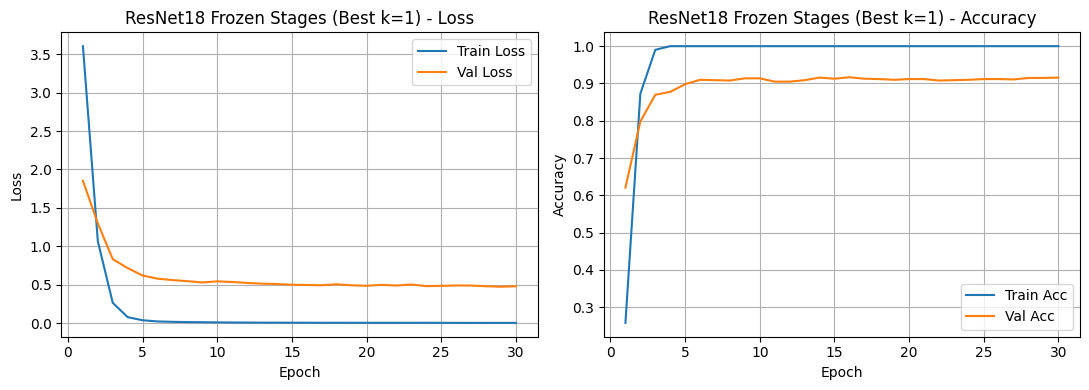

In [41]:
# Loss and Accuracy curves

plot_loss_and_accuracy(
    best_frozen_result["train_losses"],
    best_frozen_result["train_accuracies"],
    best_frozen_result["val_losses"],
    best_frozen_result["val_accuracies"],
    title=f"ResNet18 Frozen Stages (Best k={best_frozen_k})"
)

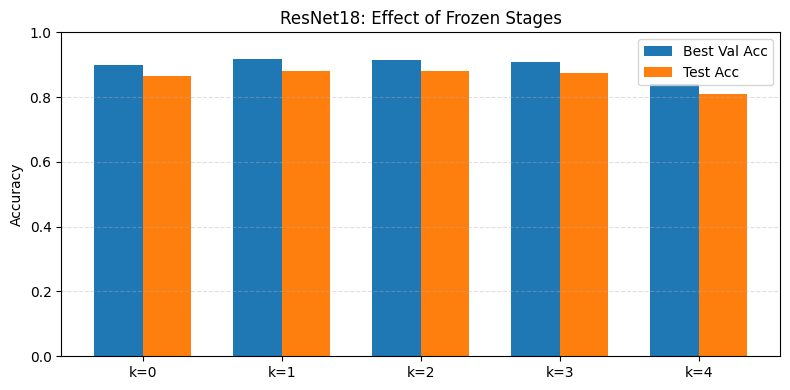

In [42]:
# Summary Bar Plots for Different Number of Frozen Stages

def plot_frozen_summary_bar(results_dict):
    ks = sorted(results_dict.keys())
    val_scores = [results_dict[k]["best_val_acc"] for k in ks]
    test_scores = [results_dict[k]["test_acc"] for k in ks]

    x = np.arange(len(ks))
    w = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - w/2, val_scores, width=w, label="Best Val Acc")
    plt.bar(x + w/2, test_scores, width=w, label="Test Acc")
    plt.xticks(x, [f"k={k}" for k in ks])
    plt.ylim(0.0, 1.0)
    plt.ylabel("Accuracy")
    plt.title("ResNet18: Effect of Frozen Stages")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_frozen_summary_bar(frozen_results)